# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from pycaret.classification import ClassificationExperiment
from datetime import datetime
import patsy
import logging

pd.set_option("display.max_columns", None)

# Data preparation

In [2]:
data_path = os.path.join("..", "data", "games.csv")
df = pd.read_csv(data_path, parse_dates=["Date", "Open"], date_format="%Y-%m-%d", index_col=0)
df = df[df["Season"] > 20]
df.head()

,Season,Date,HID,AID,N,POFF,Open,OddsH,OddsA,H,A,HSC,ASC,HFGM,AFGM,HFGA,AFGA,HFG3M,AFG3M,HFG3A,AFG3A,HFTM,AFTM,HFTA,AFTA,HORB,AORB,HDRB,ADRB,HRB,ARB,HAST,AAST,HSTL,ASTL,HBLK,ABLK,HTOV,ATOV,HPF,APF
23739,21,1995-11-07,0,11,0,0,1995-11-06,1.274083,3.794318,0,1,66,108,25.0,39.0,65.0,79.0,3.0,7.0,17.0,13.0,13.0,23.0,22.0,32.0,4.0,13.0,25.0,36.0,29.0,49.0,13.0,22.0,6.0,10.0,3.0,5.0,23.0,16.0,24.0,21.0
23740,21,1995-11-07,17,43,0,0,1995-11-06,1.597972,2.286949,1,0,114,106,46.0,40.0,83.0,77.0,6.0,13.0,12.0,30.0,16.0,13.0,24.0,17.0,12.0,4.0,31.0,25.0,43.0,29.0,30.0,29.0,11.0,7.0,1.0,5.0,21.0,21.0,19.0,25.0
23741,21,1995-11-08,41,39,0,0,1995-11-07,1.471072,2.640288,0,1,87,91,30.0,36.0,75.0,84.0,3.0,1.0,16.0,11.0,24.0,18.0,39.0,33.0,10.0,10.0,42.0,36.0,52.0,46.0,18.0,17.0,5.0,6.0,6.0,4.0,19.0,15.0,31.0,31.0
23742,21,1995-11-08,15,22,0,0,1995-11-07,1.257454,3.967424,0,1,97,105,31.0,43.0,72.0,93.0,8.0,2.0,21.0,14.0,27.0,17.0,34.0,25.0,13.0,11.0,35.0,27.0,48.0,38.0,19.0,26.0,3.0,12.0,9.0,0.0,22.0,8.0,23.0,25.0
23743,21,1995-11-08,13,19,0,0,1995-11-07,1.302199,3.542703,1,0,88,75,31.0,26.0,74.0,78.0,3.0,4.0,9.0,17.0,23.0,19.0,25.0,22.0,15.0,17.0,32.0,25.0,47.0,42.0,19.0,11.0,10.0,9.0,6.0,4.0,17.0,18.0,22.0,24.0


In [3]:
columnsH = ["HSC", "HFGM", "HFGA", "HFG3M", "HFG3A", "HFTM", "HFTA", "HORB", "HDRB", "HRB", "HAST", "HSTL", "HBLK", "HTOV", "HPF"]
columnsA = ["ASC", "AFGM", "AFGA", "AFG3M", "AFG3A", "AFTM", "AFTA", "AORB", "ADRB", "ARB", "AAST", "ASTL", "ABLK", "ATOV", "APF"]

In [4]:
meta_columns = ["Season", "Date", "HID", "AID", "N", "POFF", "Open", "OddsH", "OddsA", "H", "A", "SortedTID"]
df["SortedTID"] = df[["HID", "AID"]].apply(lambda x: tuple(sorted(x)), axis=1)
df[meta_columns].head()

,Season,Date,HID,AID,N,POFF,Open,OddsH,OddsA,H,A,SortedTID
23739,21,1995-11-07,0,11,0,0,1995-11-06,1.274083,3.794318,0,1,"(0, 11)"
23740,21,1995-11-07,17,43,0,0,1995-11-06,1.597972,2.286949,1,0,"(17, 43)"
23741,21,1995-11-08,41,39,0,0,1995-11-07,1.471072,2.640288,0,1,"(39, 41)"
23742,21,1995-11-08,15,22,0,0,1995-11-07,1.257454,3.967424,0,1,"(15, 22)"
23743,21,1995-11-08,13,19,0,0,1995-11-07,1.302199,3.542703,1,0,"(13, 19)"


## Feature creation

### Aggregated data from the whole season (!Future data)

In [5]:
df_seaH = df.groupby(["Season", "HID"])[columnsH].mean().reset_index()
df_seaA = df.groupby(["Season", "AID"])[columnsA].mean().reset_index()

sufix = "_mean"

df_ml1 = pd.merge(df[meta_columns], df_seaA, on=["Season", "AID"])
df_ml1 = pd.merge(df_ml1, df_seaH, on=["Season", "HID"])
df_ml1.head()


,Season,Date,HID,AID,N,POFF,Open,OddsH,OddsA,H,A,SortedTID,ASC,AFGM,AFGA,AFG3M,AFG3A,AFTM,AFTA,AORB,ADRB,ARB,AAST,ASTL,ABLK,ATOV,APF,HSC,HFGM,HFGA,HFG3M,HFG3A,HFTM,HFTA,HORB,HDRB,HRB,HAST,HSTL,HBLK,HTOV,HPF
0,21,1995-11-07,0,11,0,0,1995-11-06,1.274083,3.794318,0,1,"(0, 11)",96.978261,35.891304,80.152174,6.391304,15.804348,18.804348,26.065217,11.369565,30.608696,41.978261,20.934783,7.586957,4.608696,16.608696,24.456522,94.418605,35.976744,75.046512,5.930233,17.511628,16.534884,25.046512,9.860465,30.139535,40.0,19.093023,7.0,5.860465,14.72093,20.627907
1,21,1996-03-13,0,11,0,0,1996-03-12,1.595060,2.293425,1,0,"(0, 11)",96.978261,35.891304,80.152174,6.391304,15.804348,18.804348,26.065217,11.369565,30.608696,41.978261,20.934783,7.586957,4.608696,16.608696,24.456522,94.418605,35.976744,75.046512,5.930233,17.511628,16.534884,25.046512,9.860465,30.139535,40.0,19.093023,7.0,5.860465,14.72093,20.627907
2,21,1996-05-03,0,11,0,1,1996-05-02,2.043143,1.731877,0,1,"(0, 11)",96.978261,35.891304,80.152174,6.391304,15.804348,18.804348,26.065217,11.369565,30.608696,41.978261,20.934783,7.586957,4.608696,16.608696,24.456522,94.418605,35.976744,75.046512,5.930233,17.511628,16.534884,25.046512,9.860465,30.139535,40.0,19.093023,7.0,5.860465,14.72093,20.627907
3,21,1996-05-05,0,11,0,1,1996-05-04,2.147690,1.667978,0,1,"(0, 11)",96.978261,35.891304,80.152174,6.391304,15.804348,18.804348,26.065217,11.369565,30.608696,41.978261,20.934783,7.586957,4.608696,16.608696,24.456522,94.418605,35.976744,75.046512,5.930233,17.511628,16.534884,25.046512,9.860465,30.139535,40.0,19.093023,7.0,5.860465,14.72093,20.627907
4,21,1995-12-20,0,43,0,0,1995-12-19,2.079450,1.708388,0,1,"(0, 43)",109.934783,41.304348,83.673913,9.478261,23.217391,17.847826,22.652174,8.739130,30.695652,39.434783,26.760870,7.043478,4.369565,15.173913,21.108696,94.418605,35.976744,75.046512,5.930233,17.511628,16.534884,25.046512,9.860465,30.139535,40.0,19.093023,7.0,5.860465,14.72093,20.627907


In [6]:
features = columnsA + columnsH
formula = "H ~ " + " + ".join(features)
print(formula)

model = smf.logit(formula=formula, data=df_ml1)
res = model.fit()
res.summary()

H ~ ASC + AFGM + AFGA + AFG3M + AFG3A + AFTM + AFTA + AORB + ADRB + ARB + AAST + ASTL + ABLK + ATOV + APF + HSC + HFGM + HFGA + HFG3M + HFG3A + HFTM + HFTA + HORB + HDRB + HRB + HAST + HSTL + HBLK + HTOV + HPF
         Current function value: 0.569223
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      H   No. Observations:                 5251
Model:                          Logit   Df Residuals:                     5222
Method:                           MLE   Df Model:                           28
Date:                Thu, 07 Nov 2024   Pseudo R-squ.:                  0.1521
Time:                        00:17:56   Log-Likelihood:                -2989.0
converged:                      False   LL-Null:                       -3525.1
Covariance Type:            nonrobust   LLR p-value:                7.182e-208
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1731      1.903     -1.142      0.253      -5.902       1.556
ASC           -0.1213   8551.768  -1.42e-05      1.000   -1.68e+04    1.68e+04
AFGM           0.0014   1.71e+04   7.94e-08      1.000   -3.35e+04    3.35e+04
AFGA           0.2859      0.027     10.620      0.000       0.233       0.339
AFG3M         -0.0787   8549.333  -9.21e-06      1.000   -1.68e+04    1.68e+04
AFG3A          0.0161      0.041      0.393      0.695      -0.064       0.096
AFTM          -0.0481   8557.682  -5.62e-06      1.000   -1.68e+04    1.68e+04
AFTA           0.1474      0.041      3.585      0.000       0.067       0.228
AORB          -0.1339   3.78e+04  -3.54e-06      1.000   -7.42e+04    7.42e+04
ADRB          -0.0700   3.78e+04  -1.85e-06      1.000   -7.42e+04    7.42e+04
ARB           -0.2031   3.78e+04  -5.37e-06      1.000   -7.42e+04    7.42e+04
AAST          -0.0448      0.024     -1.865      0.062      -0.092       0.002
ASTL          -0.3133      0.053     -5.925      0.000      -0.417      -0.210
ABLK          -0.0186      0.051     -0.361      0.718      -0.119       0.082
ATOV           0.3101      0.030     10.245      0.000       0.251       0.369
APF           -0.0197      0.027     -0.737      0.461      -0.072       0.033
HSC            0.1158   2.13e+04   5.43e-06      1.000   -4.18e+04    4.18e+04
HFGM           0.0130   4.26e+04   3.06e-07      1.000   -8.35e+04    8.35e+04
HFGA          -0.2801      0.024    -11.548      0.000      -0.328      -0.233
HFG3M          0.0878   2.13e+04   4.12e-06      1.000   -4.18e+04    4.18e+04
HFG3A         -0.0202      0.044     -0.458      0.647      -0.106       0.066
HFTM           0.0028   2.13e+04    1.3e-07      1.000   -4.18e+04    4.18e+04
HFTA          -0.0856      0.042     -2.058      0.040      -0.167      -0.004
HORB           0.1327        nan        nan        nan         nan         nan
HDRB           0.0847        nan        nan        nan         nan         nan
HRB            0.2179        nan        nan        nan         nan         nan
HAST           0.0440      0.019      2.271      0.023       0.006       0.082
HSTL           0.2775      0.043      6.511      0.000       0.194       0.361
HBLK           0.0609      0.037      1.641      0.101      -0.012       0.134
HTOV          -0.2962      0.034     -8.692      0.000      -0.363      -0.229
HPF           -0.0055      0.029     -0.189      0.850      -0.063       0.052
==============================================================================
"""

In [7]:
features = [
    "HFGM", "HFGA", "HFG3M", "HFG3A", "HFTM", "HFTA", "HORB", "HDRB", "HAST", "HSTL", "HBLK", "HTOV",
    "AFGM", "AFGA", "AFG3M", "AFG3A", "AFTM", "AFTA", "AORB", "ADRB", "AAST", "ASTL", "ABLK", "ATOV",
]

# features = [
#     "HFGM", "HFGA", "HFG3M", "HFTM", "HFTA", "HORB", "HDRB", "HAST", "HSTL", "HBLK", "HTOV",
#     "AFGM", "AFGA", "AFG3M", "AFTM", "AFTA", "AORB", "ADRB", "AAST", "ASTL", "ABLK", "ATOV",
# ]
# features = [
#     "HFGM", "HFGA", "HFG3M", "HFTM", "HFTA", "HORB", "HDRB", "HAST", "HSTL", "HTOV",
#     "AFGM", "AFGA", "AFG3M", "AFTM", "AFTA", "AORB", "ADRB", "AAST", "ASTL", "ATOV",
# ]

formula = "H ~ " + " + ".join(features)
print(formula)

model = smf.logit(formula=formula, data=df_ml1)
res = model.fit()
res.summary()

H ~ HFGM + HFGA + HFG3M + HFG3A + HFTM + HFTA + HORB + HDRB + HAST + HSTL + HBLK + HTOV + AFGM + AFGA + AFG3M + AFG3A + AFTM + AFTA + AORB + ADRB + AAST + ASTL + ABLK + ATOV
Optimization terminated successfully.
         Current function value: 0.569278
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      H   No. Observations:                 5251
Model:                          Logit   Df Residuals:                     5226
Method:                           MLE   Df Model:                           24
Date:                Thu, 07 Nov 2024   Pseudo R-squ.:                  0.1520
Time:                        00:17:56   Log-Likelihood:                -2989.3
converged:                       True   LL-Null:                       -3525.1
Covariance Type:            nonrobust   LLR p-value:                5.145e-211
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6061      1.803     -1.446      0.148      -6.140       0.927
HFGM           0.2460      0.037      6.703      0.000       0.174       0.318
HFGA          -0.2809      0.023    -11.995      0.000      -0.327      -0.235
HFG3M          0.2011      0.107      1.883      0.060      -0.008       0.410
HFG3A         -0.0194      0.044     -0.443      0.658      -0.105       0.066
HFTM           0.1183      0.047      2.516      0.012       0.026       0.210
HFTA          -0.0869      0.041     -2.125      0.034      -0.167      -0.007
HORB           0.3506      0.040      8.751      0.000       0.272       0.429
HDRB           0.3047      0.028     10.750      0.000       0.249       0.360
HAST           0.0429      0.019      2.286      0.022       0.006       0.080
HSTL           0.2777      0.043      6.517      0.000       0.194       0.361
HBLK           0.0616      0.037      1.666      0.096      -0.011       0.134
HTOV          -0.2986      0.033     -9.084      0.000      -0.363      -0.234
AFGM          -0.2393      0.040     -5.930      0.000      -0.318      -0.160
AFGA           0.2866      0.027     10.657      0.000       0.234       0.339
AFG3M         -0.2013      0.101     -1.992      0.046      -0.399      -0.003
AFG3A          0.0155      0.041      0.379      0.704      -0.065       0.096
AFTM          -0.1733      0.050     -3.471      0.001      -0.271      -0.075
AFTA           0.1464      0.041      3.564      0.000       0.066       0.227
AORB          -0.3406      0.044     -7.788      0.000      -0.426      -0.255
ADRB          -0.2696      0.029     -9.348      0.000      -0.326      -0.213
AAST          -0.0467      0.024     -1.954      0.051      -0.093       0.000
ASTL          -0.3154      0.053     -5.974      0.000      -0.419      -0.212
ABLK          -0.0164      0.051     -0.319      0.749      -0.117       0.084
ATOV           0.3032      0.029     10.519      0.000       0.247       0.360
==============================================================================
"""

### Aggregated data from the last season

In [8]:
df["LastSeason"] = df["Season"] - 1

meta_columns = ["LastSeason", "Date", "HID", "AID", "N", "POFF", "Open", "OddsH", "OddsA", "H", "A", "SortedTID"]

df_ml2 = pd.merge(df[meta_columns], df_seaA, left_on=["LastSeason", "AID"], right_on=["Season", "AID"])
df_ml2 = pd.merge(df_ml2, df_seaH, left_on=["LastSeason", "HID"], right_on=["Season", "HID"])
df_ml2.head()

,LastSeason,Date,HID,AID,N,POFF,Open,OddsH,OddsA,H,A,SortedTID,Season_x,ASC,AFGM,AFGA,AFG3M,AFG3A,AFTM,AFTA,AORB,ADRB,ARB,AAST,ASTL,ABLK,ATOV,APF,Season_y,HSC,HFGM,HFGA,HFG3M,HFG3A,HFTM,HFTA,HORB,HDRB,HRB,HAST,HSTL,HBLK,HTOV,HPF
0,21,1996-11-05,8,12,0,0,1996-11-04,1.498635,2.548866,0,1,"(8, 12)",21,97.860000,36.040000,79.200000,4.320000,13.320000,21.460000,29.100000,12.640000,29.480000,42.120000,23.240000,7.020000,3.660000,15.980000,25.300000,21,110.021739,40.608696,84.847826,9.0,24.217391,19.804348,28.173913,11.521739,30.565217,42.086957,25.673913,9.456522,6.413043,15.23913,23.847826
1,21,1996-12-05,8,1,0,0,1996-12-04,1.529088,2.458521,1,0,"(1, 8)",21,95.363636,34.568182,79.090909,8.068182,22.159091,18.159091,23.568182,10.318182,32.750000,43.068182,19.863636,7.000000,4.181818,14.750000,21.840909,21,110.021739,40.608696,84.847826,9.0,24.217391,19.804348,28.173913,11.521739,30.565217,42.086957,25.673913,9.456522,6.413043,15.23913,23.847826
2,21,1997-03-28,8,1,0,0,1997-03-27,1.672292,2.140028,0,1,"(1, 8)",21,95.363636,34.568182,79.090909,8.068182,22.159091,18.159091,23.568182,10.318182,32.750000,43.068182,19.863636,7.000000,4.181818,14.750000,21.840909,21,110.021739,40.608696,84.847826,9.0,24.217391,19.804348,28.173913,11.521739,30.565217,42.086957,25.673913,9.456522,6.413043,15.23913,23.847826
3,21,1997-03-09,8,24,0,0,1997-03-08,1.268885,3.846260,1,0,"(8, 24)",21,92.463415,34.317073,77.439024,5.000000,14.756098,18.829268,24.829268,11.146341,27.853659,39.000000,17.365854,6.585366,4.804878,15.878049,24.097561,21,110.021739,40.608696,84.847826,9.0,24.217391,19.804348,28.173913,11.521739,30.565217,42.086957,25.673913,9.456522,6.413043,15.23913,23.847826
4,21,1997-04-03,8,24,0,0,1997-04-02,1.243589,4.128690,1,0,"(8, 24)",21,92.463415,34.317073,77.439024,5.000000,14.756098,18.829268,24.829268,11.146341,27.853659,39.000000,17.365854,6.585366,4.804878,15.878049,24.097561,21,110.021739,40.608696,84.847826,9.0,24.217391,19.804348,28.173913,11.521739,30.565217,42.086957,25.673913,9.456522,6.413043,15.23913,23.847826


In [9]:
features = [
    "HFGM", "HFGA", "HFG3M", "HFG3A", "HFTM", "HFTA", "HORB", "HDRB", "HAST", "HSTL", "HBLK", "HTOV",
    "AFGM", "AFGA", "AFG3M", "AFG3A", "AFTM", "AFTA", "AORB", "ADRB", "AAST", "ASTL", "ABLK", "ATOV",
]
# features = [
#     "HFGM", "HFGA", "HFG3M", "HFTM", "HFTA", "HORB", "HDRB", "HAST", "HSTL", "HTOV",
#     "AFGM", "AFGA", "AFG3M", "AFTM", "AFTA", "AORB", "ADRB", "AAST", "ASTL", "ATOV",
# ]

formula = "H ~ " + " + ".join(features)
print(formula)


model = smf.logit(formula=formula, data=df_ml2)
res = model.fit()
res.summary()

H ~ HFGM + HFGA + HFG3M + HFG3A + HFTM + HFTA + HORB + HDRB + HAST + HSTL + HBLK + HTOV + AFGM + AFGA + AFG3M + AFG3A + AFTM + AFTA + AORB + ADRB + AAST + ASTL + ABLK + ATOV
Optimization terminated successfully.
         Current function value: 0.622379
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      H   No. Observations:                 3942
Model:                          Logit   Df Residuals:                     3917
Method:                           MLE   Df Model:                           24
Date:                Thu, 07 Nov 2024   Pseudo R-squ.:                 0.07114
Time:                        00:17:56   Log-Likelihood:                -2453.4
converged:                       True   LL-Null:                       -2641.3
Covariance Type:            nonrobust   LLR p-value:                 6.740e-65
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.1014      1.967     -1.577      0.115      -6.957       0.754
HFGM          -0.0204      0.041     -0.503      0.615      -0.100       0.059
HFGA          -0.1023      0.026     -3.963      0.000      -0.153      -0.052
HFG3M          0.7550      0.130      5.796      0.000       0.500       1.010
HFG3A         -0.2587      0.053     -4.851      0.000      -0.363      -0.154
HFTM          -0.1094      0.050     -2.168      0.030      -0.208      -0.010
HFTA           0.0885      0.046      1.944      0.052      -0.001       0.178
HORB           0.1957      0.045      4.322      0.000       0.107       0.284
HDRB           0.1757      0.029      6.031      0.000       0.119       0.233
HAST           0.0990      0.021      4.733      0.000       0.058       0.140
HSTL           0.1420      0.051      2.784      0.005       0.042       0.242
HBLK           0.0561      0.039      1.428      0.153      -0.021       0.133
HTOV          -0.0592      0.038     -1.564      0.118      -0.133       0.015
AFGM          -0.2179      0.045     -4.890      0.000      -0.305      -0.131
AFGA           0.1984      0.028      7.113      0.000       0.144       0.253
AFG3M          0.1004      0.111      0.904      0.366      -0.117       0.318
AFG3A         -0.0754      0.045     -1.692      0.091      -0.163       0.012
AFTM           0.0390      0.055      0.708      0.479      -0.069       0.147
AFTA          -0.0364      0.045     -0.805      0.421      -0.125       0.052
AORB          -0.1849      0.050     -3.721      0.000      -0.282      -0.087
ADRB          -0.1461      0.033     -4.468      0.000      -0.210      -0.082
AAST           0.0281      0.028      0.989      0.323      -0.028       0.084
ASTL          -0.1009      0.060     -1.689      0.091      -0.218       0.016
ABLK          -0.1776      0.059     -3.000      0.003      -0.294      -0.062
ATOV           0.1333      0.030      4.519      0.000       0.076       0.191
==============================================================================
"""

### Rolling window last N games

In [10]:
rolling_n = 25


df_lastnH = df.groupby(["Season", "HID"]).rolling(rolling_n, closed="left")[columnsH].mean().reset_index().dropna().set_index("level_2").rename_axis(None).drop(columns=["HID", "Season"])
df_lastnA = df.groupby(["Season", "AID"]).rolling(rolling_n, closed="left")[columnsA].mean().reset_index().dropna().set_index("level_2").rename_axis(None).drop(columns="AID")

df_ml3 = pd.merge(df[meta_columns], df_lastnA, left_index=True, right_index=True)
df_ml3 = pd.merge(df_ml3, df_lastnH, left_index=True, right_index=True)
df_ml3.head()

,LastSeason,Date,HID,AID,N,POFF,Open,OddsH,OddsA,H,A,SortedTID,Season,ASC,AFGM,AFGA,AFG3M,AFG3A,AFTM,AFTA,AORB,ADRB,ARB,AAST,ASTL,ABLK,ATOV,APF,HSC,HFGM,HFGA,HFG3M,HFG3A,HFTM,HFTA,HORB,HDRB,HRB,HAST,HSTL,HBLK,HTOV,HPF
24473,20,1996-02-15,39,22,0,0,1996-02-14,1.351329,3.195158,1,0,"(22, 39)",21,98.32,38.00,83.96,5.84,17.32,16.48,23.00,12.56,26.76,39.32,19.68,7.24,2.56,14.84,22.40,90.92,34.88,80.20,5.16,13.84,16.00,22.12,11.64,31.52,43.16,18.36,6.44,4.56,13.44,19.60
24478,20,1996-02-16,3,5,0,0,1996-02-15,1.856686,1.882726,1,0,"(3, 5)",21,91.00,35.20,76.80,4.48,12.84,16.12,20.60,10.04,28.88,38.92,20.76,6.60,3.72,16.16,21.04,105.56,37.68,78.48,7.20,18.84,23.00,29.64,9.48,28.80,38.28,21.64,7.08,5.52,15.88,22.84
24479,20,1996-02-16,21,0,0,0,1996-02-15,1.489967,2.576553,1,0,"(0, 21)",21,98.44,35.96,79.76,6.88,19.36,19.64,26.00,10.20,31.88,42.08,22.16,6.48,5.64,15.04,23.04,97.64,36.52,81.00,6.64,17.68,17.96,26.56,13.16,30.80,43.96,21.56,6.96,5.44,14.56,21.32
24481,20,1996-02-16,30,4,0,0,1996-02-15,2.481544,1.520993,1,0,"(4, 30)",21,97.84,36.40,78.08,7.84,20.08,17.20,22.00,9.24,30.84,40.08,21.84,6.80,5.20,13.24,20.08,94.72,34.60,73.64,4.32,12.36,21.20,30.56,11.88,29.64,41.52,18.32,7.24,4.56,17.44,22.92
24485,20,1996-02-16,20,1,0,0,1996-02-15,1.251116,4.039071,1,0,"(1, 20)",21,95.12,34.80,78.72,8.00,22.04,17.52,22.68,10.28,32.76,43.04,20.16,7.16,4.64,15.80,21.92,103.24,37.44,78.56,7.68,18.96,20.68,25.16,11.68,31.92,43.60,21.16,6.96,5.44,13.96,21.80


In [11]:
features = [
    "HFGM", "HFGA", "HFG3M", "HFG3A", "HFTM", "HFTA", "HORB", "HDRB", "HAST", "HSTL", "HBLK", "HTOV",
    "AFGM", "AFGA", "AFG3M", "AFG3A", "AFTM", "AFTA", "AORB", "ADRB", "AAST", "ASTL", "ABLK", "ATOV",
]
# features = [
#     "HFGM", "HFGA", "HFG3M", "HFTM", "HFTA", "HORB", "HDRB", "HAST", "HSTL", "HTOV",
#     "AFGM", "AFGA", "AFG3M", "AFTM", "AFTA", "AORB", "ADRB", "AAST", "ASTL", "ATOV",
# ]

formula = "H ~ " + " + ".join(features)
print(formula)

model = smf.ols(formula=formula, data=df_ml3)
res = model.fit()
res.summary()

H ~ HFGM + HFGA + HFG3M + HFG3A + HFTM + HFTA + HORB + HDRB + HAST + HSTL + HBLK + HTOV + AFGM + AFGA + AFG3M + AFG3A + AFTM + AFTA + AORB + ADRB + AAST + ASTL + ABLK + ATOV


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      H   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     15.31
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           1.05e-57
Time:                        00:17:56   Log-Likelihood:                -1329.7
No. Observations:                2149   AIC:                             2709.
Df Residuals:                    2124   BIC:                             2851.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3420      0.515      0.664      0.506      -0.667       1.351
HFGM           0.0187      0.010      1.966      0.049    4.66e-05       0.037
HFGA          -0.0475      0.006     -7.411      0.000      -0.060      -0.035
HFG3M          0.0499      0.027      1.867      0.062      -0.003       0.102
HFG3A         -0.0015      0.011     -0.135      0.893      -0.024       0.021
HFTM           0.0347      0.014      2.547      0.011       0.008       0.061
HFTA          -0.0338      0.012     -2.913      0.004      -0.057      -0.011
HORB           0.0650      0.011      6.087      0.000       0.044       0.086
HDRB           0.0440      0.008      5.681      0.000       0.029       0.059
HAST           0.0201      0.006      3.494      0.000       0.009       0.031
HSTL           0.0630      0.012      5.234      0.000       0.039       0.087
HBLK           0.0401      0.010      3.820      0.000       0.020       0.061
HTOV          -0.0406      0.009     -4.452      0.000      -0.058      -0.023
AFGM          -0.0313      0.011     -2.760      0.006      -0.054      -0.009
AFGA           0.0439      0.007      6.367      0.000       0.030       0.057
AFG3M         -0.0163      0.025     -0.659      0.510      -0.065       0.032
AFG3A         -0.0060      0.010     -0.579      0.563      -0.026       0.014
AFTM          -0.0122      0.014     -0.895      0.371      -0.039       0.015
AFTA           0.0137      0.011      1.248      0.212      -0.008       0.035
AORB          -0.0447      0.011     -3.935      0.000      -0.067      -0.022
ADRB          -0.0350      0.007     -4.689      0.000      -0.050      -0.020
AAST          -0.0049      0.007     -0.731      0.465      -0.018       0.008
ASTL          -0.0674      0.014     -4.798      0.000      -0.095      -0.040
ABLK          -0.0127      0.014     -0.882      0.378      -0.041       0.016
ATOV           0.0379      0.008      4.911      0.000       0.023       0.053
==============================================================================
Omnibus:                     3964.549   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.597
Skew:                          -0.382   Prob(JB):                     1.24e-43
Kurtosis:                       1.726   Cond. No.                     7.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## PyCaret AutoML

In [12]:
py_cls = ClassificationExperiment()

setup_params_cls = {
    "data": df_ml3,
    "target": "H",
    "ignore_features": ["Season", "Date", "HID", "AID", "N", "POFF", "Open", "OddsH", "OddsA", "A", "SortedTID"],
}

py_cls.setup(**setup_params_cls)
model = py_cls.compare_models(turbo=True, sort="Accuracy")

,Description,Value
0,Session id,4254
1,Target,H
2,Target type,Binary
3,Original data shape,"(2149, 43)"
4,Transformed data shape,"(2149, 32)"
5,Transformed train set shape,"(1504, 32)"
6,Transformed test set shape,"(645, 32)"
7,Ignore features,11
8,Numeric features,31
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6762,0.7101,0.8259,0.7020,0.7583,0.2768,0.2862,0.0070
lda,Linear Discriminant Analysis,0.6735,0.7100,0.8205,0.7013,0.7556,0.2723,0.2806,0.0050
lr,Logistic Regression,0.6715,0.7102,0.8172,0.7005,0.7537,0.2686,0.2765,0.1490
gbc,Gradient Boosting Classifier,0.6636,0.6836,0.8270,0.6887,0.7514,0.2440,0.2543,0.0830
et,Extra Trees Classifier,0.6562,0.6744,0.8075,0.6875,0.7423,0.2349,0.2437,0.0250
rf,Random Forest Classifier,0.6543,0.6792,0.8151,0.6839,0.7433,0.2253,0.2350,0.0380
lightgbm,Light Gradient Boosting Machine,0.6522,0.6690,0.7891,0.6898,0.7360,0.2329,0.2380,0.1490
ada,Ada Boost Classifier,0.6496,0.6561,0.7643,0.6959,0.7284,0.2377,0.2399,0.0230
xgboost,Extreme Gradient Boosting,0.6489,0.6609,0.7880,0.6871,0.7337,0.2247,0.2304,0.0310
nb,Naive Bayes,0.6449,0.6604,0.7339,0.7029,0.7170,0.2399,0.2419,0.0710


In [13]:
best_model_cls = []

seasons = df["Season"].unique()
for i in range(len(seasons) - 1):
    df_train = df_ml3[df_ml3["Season"] == seasons[i]]
    df_test = df_ml3[df_ml3["Season"] == seasons[i + 1]]

    py_cls = ClassificationExperiment()

    setup_params_cls = {
        "data": df_train,
        "test_data": df_test,
        "target": "H",
        "ignore_features": ["Season", "Date", "HID", "AID", "N", "POFF", "Open", "OddsH", "OddsA", "A", "SortedTID"],
    }

    py_cls.setup(**setup_params_cls)
    best_model_cls.append((i, py_cls.compare_models(turbo=True, sort="Accuracy")))

,Description,Value
0,Session id,8843
1,Target,H
2,Target type,Binary
3,Original data shape,"(1079, 43)"
4,Transformed data shape,"(1079, 32)"
5,Transformed train set shape,"(539, 32)"
6,Transformed test set shape,"(540, 32)"
7,Ignore features,11
8,Numeric features,31
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.6401,0.6458,0.7418,0.6818,0.7082,0.2385,0.2434,0.0150
ridge,Ridge Classifier,0.6365,0.6423,0.7925,0.6594,0.7189,0.2139,0.2230,0.0040
lda,Linear Discriminant Analysis,0.6365,0.6422,0.7894,0.6602,0.7178,0.2152,0.2244,0.0060
lr,Logistic Regression,0.6346,0.6436,0.7990,0.6562,0.7196,0.2070,0.2177,0.0110
gbc,Gradient Boosting Classifier,0.6310,0.6522,0.7450,0.6696,0.7031,0.2159,0.2211,0.0390
rf,Random Forest Classifier,0.6216,0.6332,0.7516,0.6582,0.6992,0.1915,0.1993,0.0240
qda,Quadratic Discriminant Analysis,0.6161,0.6204,0.6829,0.6740,0.6736,0.2049,0.2093,0.0040
nb,Naive Bayes,0.6159,0.6346,0.6752,0.6751,0.6713,0.2060,0.2108,0.0050
et,Extra Trees Classifier,0.6049,0.6139,0.7421,0.6443,0.6885,0.1542,0.1576,0.0180
lightgbm,Light Gradient Boosting Machine,0.6049,0.6159,0.7173,0.6522,0.6816,0.1632,0.1652,0.0860


,Description,Value
0,Session id,6262
1,Target,H
2,Target type,Binary
3,Original data shape,"(1074, 43)"
4,Transformed data shape,"(1074, 32)"
5,Transformed train set shape,"(540, 32)"
6,Transformed test set shape,"(534, 32)"
7,Ignore features,11
8,Numeric features,31
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6944,0.6984,0.8442,0.7270,0.7792,0.2853,0.2946,0.0050
lr,Logistic Regression,0.6907,0.7009,0.8385,0.7262,0.7761,0.2779,0.2867,0.0090
lda,Linear Discriminant Analysis,0.6870,0.6984,0.8326,0.7240,0.7724,0.2720,0.2803,0.0050
ada,Ada Boost Classifier,0.6500,0.6342,0.7666,0.7133,0.7369,0.2125,0.2153,0.0150
rf,Random Forest Classifier,0.6481,0.6555,0.8271,0.6871,0.7489,0.1689,0.1882,0.0240
dummy,Dummy Classifier,0.6426,0.5000,1.0000,0.6426,0.7824,0.0000,0.0000,0.0040
xgboost,Extreme Gradient Boosting,0.6370,0.6637,0.7727,0.6959,0.7315,0.1742,0.1785,0.0170
lightgbm,Light Gradient Boosting Machine,0.6333,0.6434,0.7787,0.6892,0.7305,0.1614,0.1683,0.0900
gbc,Gradient Boosting Classifier,0.6259,0.6845,0.7810,0.6831,0.7266,0.1367,0.1443,0.0400
nb,Naive Bayes,0.6241,0.6323,0.7204,0.7049,0.7118,0.1683,0.1685,0.0040


,Description,Value
0,Session id,465
1,Target,H
2,Target type,Binary
3,Original data shape,"(1070, 43)"
4,Transformed data shape,"(1070, 32)"
5,Transformed train set shape,"(534, 32)"
6,Transformed test set shape,"(536, 32)"
7,Ignore features,11
8,Numeric features,31
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6836,0.6988,0.8213,0.7218,0.7673,0.2767,0.2875,0.0110
ridge,Ridge Classifier,0.6817,0.7018,0.8272,0.7179,0.7678,0.2673,0.2786,0.0050
lda,Linear Discriminant Analysis,0.6798,0.7011,0.8214,0.7182,0.7652,0.2661,0.2772,0.0030
gbc,Gradient Boosting Classifier,0.6707,0.6458,0.8273,0.7075,0.7621,0.2357,0.2450,0.0380
rf,Random Forest Classifier,0.6648,0.6412,0.8124,0.7086,0.7558,0.2267,0.2332,0.0240
lightgbm,Light Gradient Boosting Machine,0.6575,0.6398,0.8006,0.7043,0.7484,0.2158,0.2213,0.0840
ada,Ada Boost Classifier,0.6463,0.6362,0.7599,0.7079,0.7319,0.2116,0.2147,0.0150
nb,Naive Bayes,0.6444,0.6709,0.6866,0.7395,0.7089,0.2504,0.2548,0.0040
et,Extra Trees Classifier,0.6425,0.6463,0.7977,0.6920,0.7399,0.1739,0.1804,0.0180
xgboost,Extreme Gradient Boosting,0.6406,0.6397,0.7800,0.6954,0.7344,0.1813,0.1849,0.0160


In [14]:
for i, model in best_model_cls:
    print(f"{seasons[i]:>2}/{seasons[i + 1]:>2}", model)


21/22 AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=8843)
22/23 RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=6262, solver='auto',
                tol=0.0001)
23/24 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=465, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


## Simple sklearn

### Season train/test split

In [15]:
def calc_return(data, predictions):

    r = 0
    rs= []
    for p, (_, row) in zip(predictions, data.iterrows()):
        r -= 1
        if p and row["H"]:
            r += row["OddsH"]
        
        if not p and row["A"]:
            r += row["OddsA"]

        rs.append(r)

    return r, rs

def predict_proba(model, X):
    d = model.decision_function(X)
    return np.exp(d) / (1 + np.exp(d))

In [16]:
seasons = df["Season"].unique()
for i in range(len(seasons) - 1):
    df_train = df_ml1[df_ml1["Season"] == seasons[i]]
    df_test = df_ml1[df_ml1["Season"] == seasons[i + 1]]

    y_train, X_train = patsy.dmatrices(formula, df_train, return_type="matrix")
    y_test, X_test = patsy.dmatrices(formula, df_test, return_type="matrix")

    y_train = y_train.flatten()

    # model = LogisticRegression(max_iter=10_000)
    # model = GradientBoostingClassifier()
    model = RidgeClassifier()

    model.fit(X_train, y_train)


    p_train = model.predict(X_train)
    p_test = model.predict(X_test)

    bac_train = balanced_accuracy_score(y_train, p_train)
    ac_train = accuracy_score(y_train, p_train)
    bac_test = balanced_accuracy_score(y_test, p_test)
    ac_test = accuracy_score(y_test, p_test)

    r_train, _ = calc_return(df_train, p_train)
    r_test, _ = calc_return(df_test, p_test)


    print(f"{seasons[i]:>2}/{seasons[i + 1]:>2}, Acc Tr: {ac_train :.2%}, B. Acc Tr: {bac_train :.2%}, Acc Ts: {ac_test :.2%}, B. Acc Ts: {bac_test :.2%}, Return Tr: {r_train:.3f}, Return Ts: {r_test:.3f}")

21/22, Acc Tr: 67.53%, B. Acc Tr: 64.19%, Acc Ts: 69.51%, B. Acc Ts: 64.88%, Return Tr: 49.202, Return Ts: 22.327
22/23, Acc Tr: 71.48%, B. Acc Tr: 68.58%, Acc Ts: 70.95%, B. Acc Ts: 68.01%, Return Tr: 95.788, Return Ts: 53.339
23/24, Acc Tr: 71.94%, B. Acc Tr: 68.85%, Acc Ts: 69.51%, B. Acc Ts: 69.11%, Return Tr: 66.906, Return Ts: 97.508


### Random train/test split

In [17]:
df_train, df_test = train_test_split(df_ml1, test_size=0.5)

y_train, X_train = patsy.dmatrices(formula, df_train, return_type="matrix")
y_test, X_test = patsy.dmatrices(formula, df_test, return_type="matrix")

y_train = y_train.flatten()

# model = LogisticRegression(max_iter=10_000)
# model = GradientBoostingClassifier()
model = RidgeClassifier()

model.fit(X_train, y_train)


p_train = model.predict(X_train)
p_test = model.predict(X_test)
pb_train = predict_proba(model, X_train)
pb_test = predict_proba(model, X_test)

bac_train = balanced_accuracy_score(y_train, p_train)
ac_train = accuracy_score(y_train, p_train)
bac_test = balanced_accuracy_score(y_test, p_test)
ac_test = accuracy_score(y_test, p_test)

r_train, rs_train = calc_return(df_train, p_train)
r_test, rs_test = calc_return(df_test, p_test)


print(f"Acc Tr: {ac_train :.2%}, B. Acc Tr: {bac_train :.2%}, Acc Ts: {ac_test :.2%}, B. Acc Ts: {bac_test :.2%}, Return Tr: {r_train:.3f}, Return Ts: {r_test:.3f}")

Acc Tr: 69.79%, B. Acc Tr: 66.24%, Acc Ts: 69.27%, B. Acc Ts: 66.10%, Return Tr: 100.169, Return Ts: 79.734


### Bootsraping results

In [18]:
def bootstrap(p, df, n=1000):

    def _calc_return(df):
        r = 0
        rs= []
        for _, row in df.iterrows():
            r -= 1
            if row["p"] and row["H"]:
                r += row["OddsH"]
            
            if not row["p"] and row["A"]:
                r += row["OddsA"]

            rs.append(r)

        return rs

    df_p = df[["H", "A", "OddsH", "OddsA"]].copy()
    df_p["p"] = p

    rs = []
    for _ in range(n):
        df_s = df_p.sample(len(df_p), replace=True)
        rs.append(_calc_return(df_s))
    
    return rs

def calc_envelope(rs):
    rs = np.array(rs)
    return rs.min(axis=0), rs.max(axis=0)


def bootstrap_proba(p, df, offset=0.1, n=1000):

    def _calc_return(df, offset):
        r = 0
        rs= []
        for _, row in df.iterrows():
            if (1 - row["p"] + offset) < (1 / row["OddsA"]):
                r -= 1
                if row["H"]:
                    r += row["OddsH"]
    
            if row["p"] + offset < (1 / row["OddsH"]):
                r -= 1
                if row["A"]:
                    r += row["OddsA"]

            rs.append(r)

        return rs

    df_p = df[["H", "A", "OddsH", "OddsA"]].copy()
    df_p["p"] = p

    rs = []
    for _ in range(n):
        df_s = df_p.sample(len(df_p), replace=True)
        rs.append(_calc_return(df_s, offset))
    
    return rs

def calc_envelope(rs):
    rs = np.array(rs)
    return rs.min(axis=0), rs.max(axis=0), rs.mean(axis=0), np.median(rs, axis=0)

In [19]:
bs_n = 100
bs_offset = 0.3
rs = bootstrap_proba(pb_test, df_test, offset=bs_offset, n=bs_n)
rs_min, rs_max, rs_mean, rs_median = calc_envelope(rs)

In [20]:
bs_n = 1000
rs = bootstrap(p_test, df_test, n=bs_n)
rs_min, rs_max, rs_mean, rs_median = calc_envelope(rs)

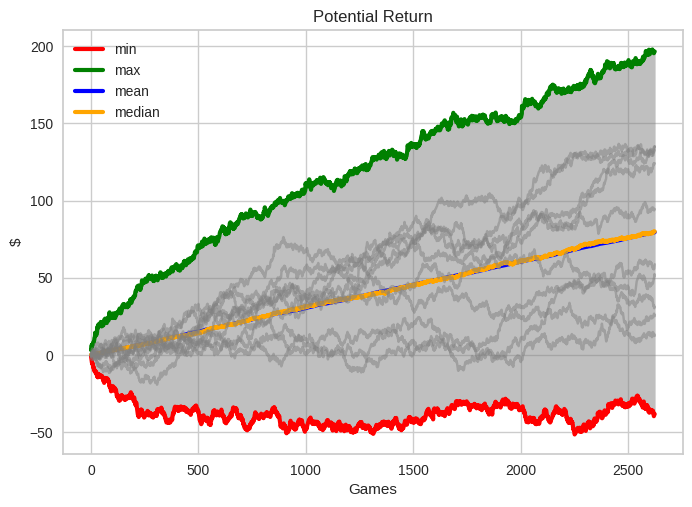

In [21]:
name3_proba = f"results_roll{rolling_n}_proba_offset{bs_offset}_test_bs{bs_n}.pdf"
name3 = f"results_roll{rolling_n}_test_bs{bs_n}.pdf"

name1_proba = f"results_allSeasonData_proba_offset{bs_offset}_test_bs{bs_n}.pdf"
name1 = f"results_allSeasonData_test_bs{bs_n}.pdf"

plt.title("Potential Return")
plt.xlabel("Games")
plt.ylabel("$")
plt.plot(rs_min, color="red", label="min", lw=3)
plt.plot(rs_max, color="green", label="max", lw=3)
plt.plot(rs_mean, color="blue", label="mean", lw=3)
plt.plot(rs_median, color="orange", label="median", lw=3)
for i in np.random.choice(range(len(rs)), 10):
    plt.plot(rs[i], color="gray", alpha=0.5)
plt.fill_between(range(len(rs_min)), rs_min, rs_max, color="gray", alpha=0.5)
plt.legend()
plt.savefig(os.path.join("..", "plots", name1))
plt.show()

In [22]:
df_p = df_train[["H", "A", "OddsH", "OddsA"]].copy()
df_p["p"] = p_train


o = []
r = 0
for _, row in df_p.iterrows():
    if row["p"]:
        r -= 1
        if row["H"]:
            o.append(row["OddsH"])
            r += row["OddsH"]
    if not row["p"]:
        r -= 1
        if row["A"]:
            o.append(row["OddsA"])
            r += row["OddsA"]

print(f"H/A, {np.mean(o):.3f}, {1 / np.mean(o):.2%}, {r:.3f}")


o = []
r = 0
for _, row in df_p.iterrows():
    if row["p"]:
        r -= 1
        if row["H"]:
            o.append(row["OddsH"])
            r += row["OddsH"]

print(f"  H, {np.mean(o):.3f}, {1 / np.mean(o):.2%}, {r:.3f}")

o = []
r = 0
for _, row in df_p.iterrows():
    if not row["p"]:
        r -= 1
        if row["A"]:
            o.append(row["OddsA"])
            r += row["OddsA"]

print(f"  A, {np.mean(o):.3f}, {1 / np.mean(o):.2%}, {r:.3f}")


H/A, 1.488, 67.23%, 100.169
  H, 1.390, 71.95%, 3.333
  A, 1.738, 57.52%, 96.836


In [23]:
df_p = df_test[["H", "A", "OddsH", "OddsA"]].copy()
df_p["p"] = p_test


o = []
r = 0
for _, row in df_p.iterrows():
    if row["p"]:
        r -= 1
        if row["H"]:
            o.append(row["OddsH"])
            r += row["OddsH"]
    if not row["p"]:
        r -= 1
        if row["A"]:
            o.append(row["OddsA"])
            r += row["OddsA"]

print(f"H/A, {np.mean(o):.3f}, {1 / np.mean(o):.2%}, {r:.3f}")


o = []
r = 0
for _, row in df_p.iterrows():
    if row["p"]:
        r -= 1
        if row["H"]:
            o.append(row["OddsH"])
            r += row["OddsH"]

print(f"  H, {np.mean(o):.3f}, {1 / np.mean(o):.2%}, {r:.3f}")

o = []
r = 0
for _, row in df_p.iterrows():
    if not row["p"]:
        r -= 1
        if row["A"]:
            o.append(row["OddsA"])
            r += row["OddsA"]

print(f"  A, {np.mean(o):.3f}, {1 / np.mean(o):.2%}, {r:.3f}")


H/A, 1.487, 67.23%, 79.734
  H, 1.376, 72.68%, -42.224
  A, 1.761, 56.79%, 121.958
